In [1]:
import nibabel as nib
from nibabel.processing import resample_to_output
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
from glob import glob
import re
import os

seed = 42
np.random.seed(seed)  # for reproducibility
import matplotlib.animation as animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

In [2]:
data_t1 = np.load("/Dedicated/jmichaelson-sdata/comppsych/lesion/Hackathon_Lesion_Data/t1_np_array.npy")
lables_t1 = np.load("/Dedicated/jmichaelson-sdata/comppsych/lesion/Hackathon_Lesion_Data/t1_labels.npy")

data_array_mask = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array.npy")
labels_array_mask = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_labels.npy")

data_array_flattened = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array_flattened.npy")
labels_array = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_labels.npy")
data_array_flattened_reduced = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array_flattened_reduced.npy")

In [3]:
all_masks = data_array_mask.sum(axis=0)
all_masks.shape

(182, 218, 182)

In [4]:
from numpy import *    

def get_cube(mask, s=0, e=182, everything=False):
    if everything:
        cube = mask
    else:
        cube = mask[s:e, s:e, s:e]
    flat = cube.flatten()
    positions = np.where(cube > -1)
    return cube, flat, positions

def cutoff(flat, value):
    return np.array([0 if x < value else x for x in flat])

def norm(a):
    return a / max(a.flatten())

def log_transform(a):
    x = ma.log(a)
    return x.filled(0)

In [5]:
CUTOFF_VALUE = 0

<IPython.core.display.Javascript object>


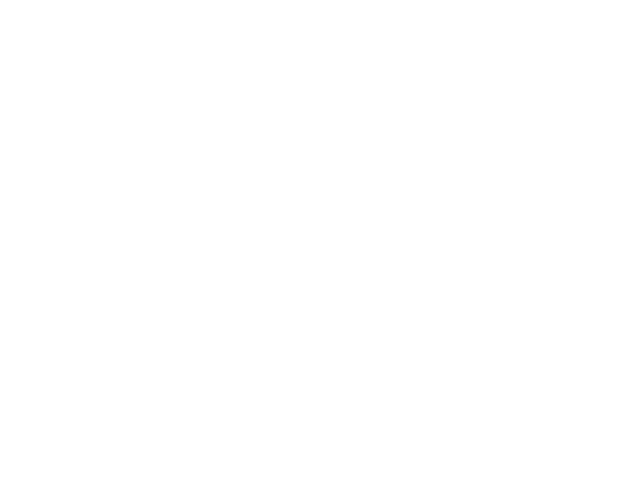

1640858

In [6]:
%matplotlib notebook

cube,  cube_flat, positions = get_cube(all_masks, everything = True)
cube_cut = cutoff(cube_flat, CUTOFF_VALUE)
plt.hist(cube_flat, bins = 30)
plt.axvline(x=CUTOFF_VALUE, c='r')
plt.yscale('log', nonposy='clip')
plt.title("Distribution of sum values")
plt.show()
len(cube_cut[cube_cut != 0])

In [7]:
non_zeroes = cube_cut != 0
non_zero_positions = np.apply_along_axis(lambda x: x[non_zeroes], 1, positions)
non_zero_cube = cube_cut[non_zeroes]
non_zero_cube.shape
nz_cube_normalized = norm(non_zero_cube)

rgba_colors = cm.viridis(nz_cube_normalized)
# the fourth column needs to be the alphas
rgba_colors[:, 3] = nz_cube_normalized**5
rgba_colors.shape

(1640858, 4)

<IPython.core.display.Javascript object>


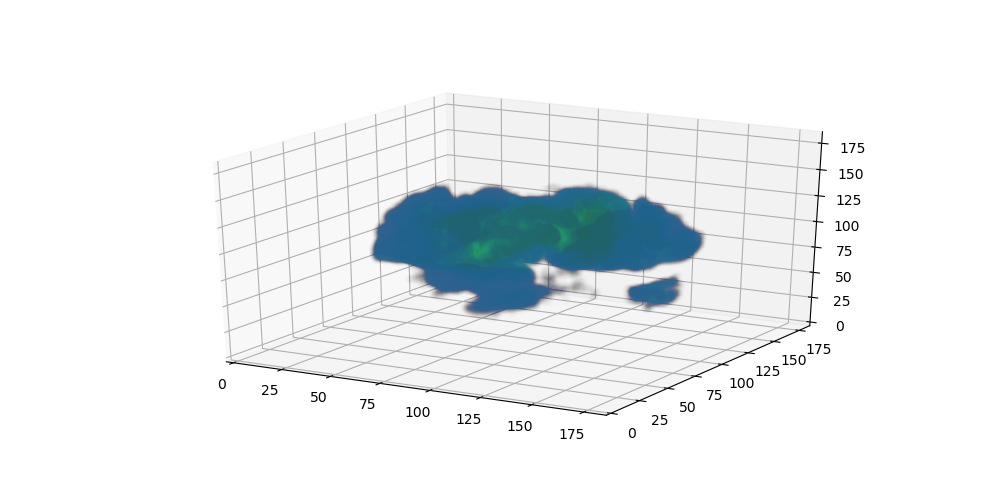

In [8]:
%matplotlib notebook
fig = plt.figure("Lesion mask 3D", figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


ax.scatter(non_zero_positions[0], non_zero_positions[1], non_zero_positions[2], color = rgba_colors, marker='s', edgecolors='none')
ax.set_xlim3d(0, cube.shape[0])
ax.set_ylim3d(0, cube.shape[0])
ax.set_zlim3d(0, cube.shape[0])
ax.view_init(elev=25.)
# ax.set_title("All lesion masks combined, cutoff {}".format(CUTOFF_VALUE))
fig.canvas.draw()

<IPython.core.display.Javascript object>


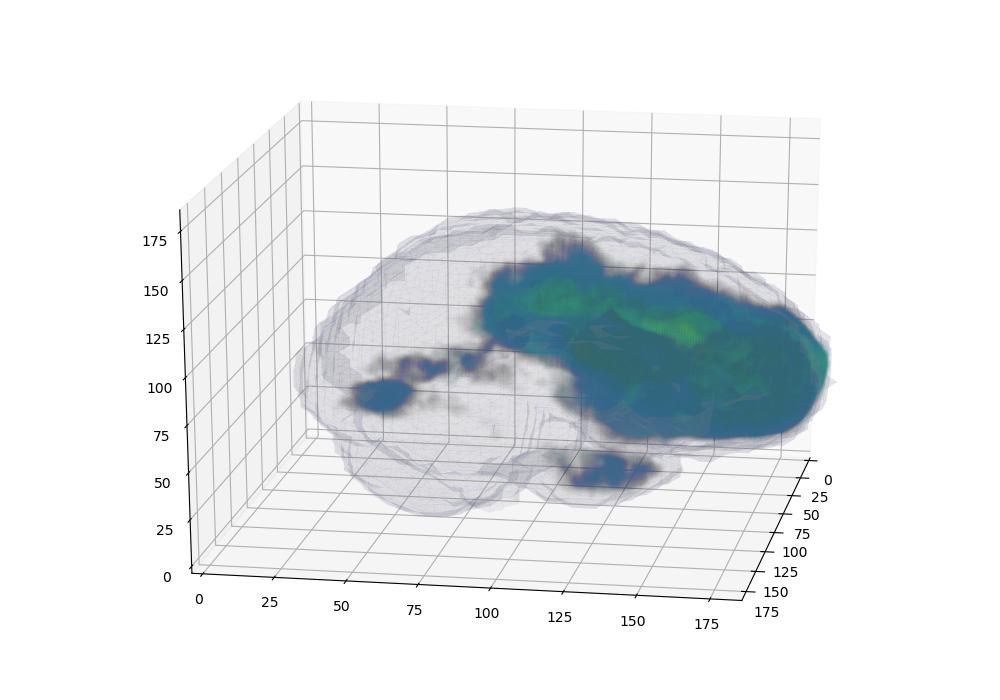

In [9]:
%matplotlib notebook
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes_lewiner(data_t1[0,:,:,:], 0, step_size = 4)
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure("Lesion mask 3D" ,figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
alpha = 0.1
fc = "gray"
# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces], alpha = alpha, facecolor=fc, linewidths=.1)
edge_color = [.5,.5,1,0.1]
mesh.set_edgecolor(edge_color)
ax.add_collection3d(mesh)
ax.scatter(non_zero_positions[0], non_zero_positions[1], non_zero_positions[2], color = rgba_colors, marker='s', edgecolors='none')

ax.set_xlim3d(0, cube.shape[0])
ax.set_ylim3d(0, cube.shape[0])
ax.set_zlim3d(0, cube.shape[0])
ax.view_init(elev=20., azim=10) 

plt.tight_layout()
plt.show()